# LG3 tokenizer evaluation (generalist vs LG3 VQ-VAE)

This demo compares two tokenizers on LG3 data:
1) reconstruction error (MSE/MAE)
2) codebook usage distribution

Fill in the checkpoint paths below.


In [3]:
import os, sys, torch, json
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/home/jeonchanwook/Documents/Github/TOTEM")

ROOT = "/home/jeonchanwook/Documents/Github/TOTEM"
sys.path.insert(0, ROOT)
sys.path.insert(0, os.path.join(ROOT, "forecasting"))  # <- 중요: lib 패키지 해결

from lg3.lib.models.vqvae import vqvae as lg3_vqvae
from forecasting.lib.models.vqvae import vqvae as gen_vqvae

LG3_VQVAE_CKPT = "../saved_models/CD64_CW256_CF4_BS2048_ITR15000/checkpoints/final_model.pth"
GENERALIST_CKPT = "../../data/TOTEM_data_and_pretrained_tokenizers/generatlist_pretrained_tokenizers/forecasting/CD64_CW256_CF4_BS4096_ITR120000/checkpoints/final_model.pth"

lg3_model = torch.load(LG3_VQVAE_CKPT, weights_only=False).eval()
gen_model = torch.load(GENERALIST_CKPT, weights_only=False).eval()

lg3_cf = getattr(lg3_model, "compression_factor", 4)
gen_cf = getattr(gen_model, "compression_factor", 4)


In [4]:
SAMPLE_SIZE = 5000  # reduce for speed
REVIN_ROOT = os.path.abspath(os.path.join('..', 'data'))
SOURCE = 'snu'  # elec1_f2 / ohsung_f2 / snu (set to '' if using single-source revin)

if SOURCE:
    LG3_REVIN_DIR = os.path.join(REVIN_ROOT, 'revin_sources', SOURCE)
else:
    LG3_REVIN_DIR = os.path.join(REVIN_ROOT, 'revin')

FEATURE_MAP_PATH = os.path.join(LG3_REVIN_DIR, 'feature_map.json')

def load_revin_x(path):
    x_full = np.load(path, mmap_mode="r")
    print("full shape:", x_full.shape)
    if len(x_full) > SAMPLE_SIZE:
        idx = np.random.choice(len(x_full), size=SAMPLE_SIZE, replace=False)
        x = np.array(x_full[idx])
    else:
        x = np.array(x_full)
    return x

x_train = load_revin_x(os.path.join(LG3_REVIN_DIR, 'train_data_x.npy'))
print('x_train shape:', x_train.shape)

if os.path.exists(FEATURE_MAP_PATH):
    with open(FEATURE_MAP_PATH, 'r') as fh:
        feature_map = json.load(fh)
    print('feature_map keys:', list(feature_map.keys()))
    print('features:', feature_map.get('features', []))


full shape: (142096, 288)
x_train shape: (5000, 288)
feature_map keys: ['features', 'index_by_feature']
features: ['MFR_068', 'Comp1 Hz_1', 'Comp1 Hz_0', 'Power', 'VAP_Entha', 'LIQ_Entha', 'Tcond', 'Tod']


## 1) Reconstruction error
We encode/decode and compare to the original.


In [5]:
def reconstruct(model, x, compression_factor):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = model.to(device).eval()
    x_t = torch.tensor(x, dtype=torch.float32, device=device)
    with torch.no_grad():
        z = model.encoder(x_t, compression_factor)
        vq_loss, quantized, perplexity, embedding_weight, encoding_indices, encodings = model.vq(z)
        recon = model.decoder(quantized, compression_factor)
    recon = recon.detach().cpu().numpy()
    return recon, encoding_indices.detach().cpu().numpy(), embedding_weight.detach().cpu().numpy()

def mse_mae(x, recon):
    mse = np.mean((x - recon) ** 2)
    mae = np.mean(np.abs(x - recon))
    return mse, mae

lg3_model = torch.load(LG3_VQVAE_CKPT, weights_only=False)
gen_model = torch.load(GENERALIST_CKPT, weights_only=False)

lg3_compression_factor = getattr(lg3_model, 'compression_factor', 4)
gen_compression_factor = getattr(gen_model, 'compression_factor', 4)

lg3_recon, lg3_codes, lg3_codebook = reconstruct(lg3_model, x_train, lg3_compression_factor)
gen_recon, gen_codes, gen_codebook = reconstruct(gen_model, x_train, gen_compression_factor)

lg3_mse, lg3_mae = mse_mae(x_train, lg3_recon)
gen_mse, gen_mae = mse_mae(x_train, gen_recon)

print('LG3 tokenizer  MSE/MAE:', lg3_mse, lg3_mae)
print('Generalist   MSE/MAE:', gen_mse, gen_mae)


LG3 tokenizer  MSE/MAE: 0.025414694 0.09709323
Generalist   MSE/MAE: 0.056247693 0.123617545


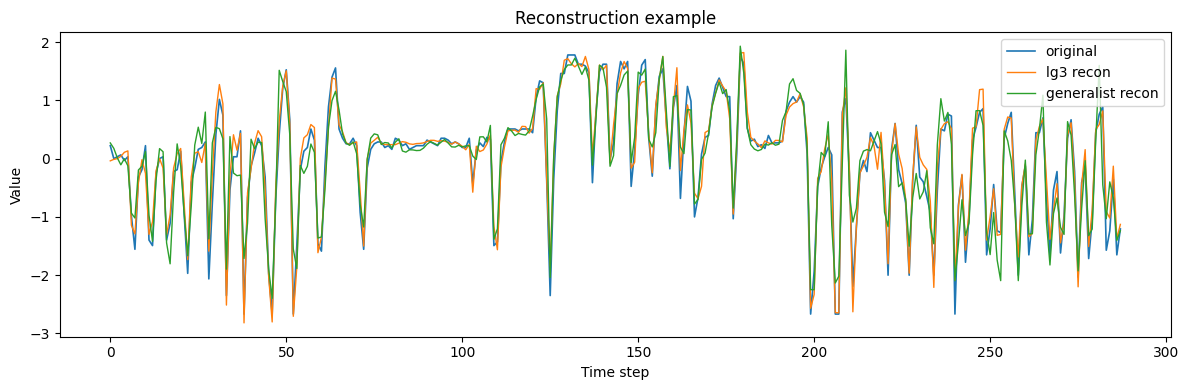

In [6]:
# visualize a single example reconstruction
idx = 0
plt.figure(figsize=(12, 4))
plt.plot(x_train[idx], label='original', linewidth=1.2)
plt.plot(lg3_recon[idx], label='lg3 recon', linewidth=1.0)
plt.plot(gen_recon[idx], label='generalist recon', linewidth=1.0)
plt.title('Reconstruction example')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()


## 2) Codebook usage
We visualize token usage distribution.


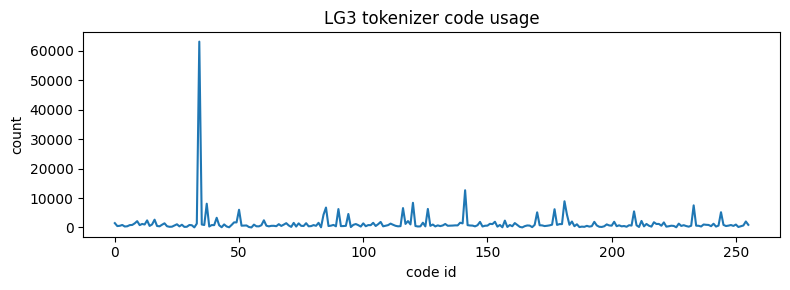

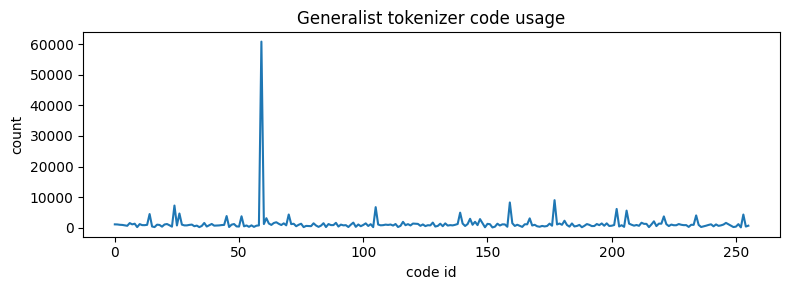

In [7]:
def plot_code_usage(code_ids, title):
    # code_ids shape: (N, 1) or (N, ...)
    flat = code_ids.reshape(-1)
    counts = np.bincount(flat)
    plt.figure(figsize=(8, 3))
    plt.plot(counts)
    plt.title(title)
    plt.xlabel('code id')
    plt.ylabel('count')
    plt.tight_layout()
    plt.show()

plot_code_usage(lg3_codes, 'LG3 tokenizer code usage')
plot_code_usage(gen_codes, 'Generalist tokenizer code usage')


## 3) Random reconstruction overlay
Re-run this cell to get a new random seed and new samples.


Random seed: 16149


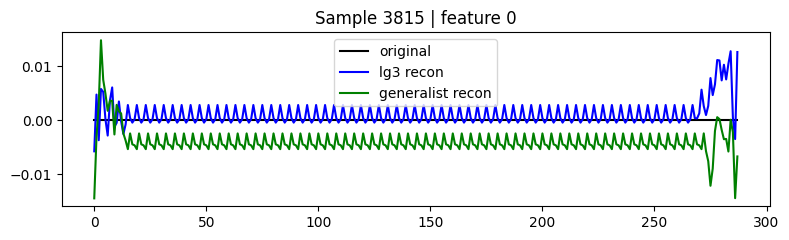

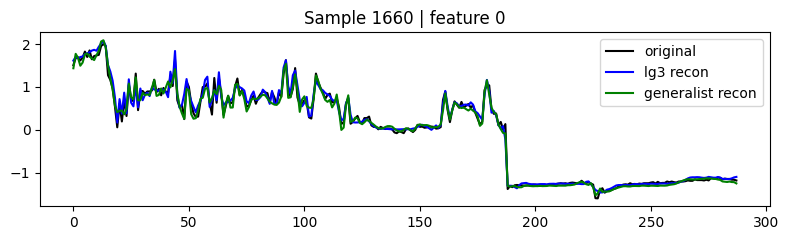

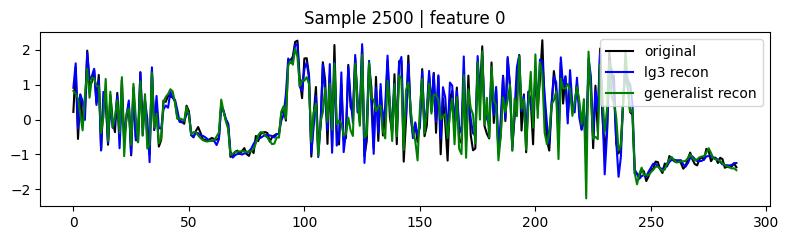

In [8]:
import time

feature_idx = 0  # change to inspect a different feature
num_samples = 3

seed = int(time.time()) % 100000
np.random.seed(seed)
print('Random seed:', seed)

idx = np.random.choice(len(x_train), size=num_samples, replace=False)
for i, s in enumerate(idx):
    plt.figure(figsize=(8, 2.5))
    plt.plot(x_train[s], color='black', label='original')
    plt.plot(lg3_recon[s], color='blue', label='lg3 recon')
    plt.plot(gen_recon[s], color='green', label='generalist recon')
    plt.title(f'Sample {s} | feature {feature_idx}')
    plt.legend()
    plt.tight_layout()
    plt.show()
